## FLAGS (IMPORTANT)

In [1]:
VALIDATE_NN = False
TRAIN = True
VALIDATE_SVM = True

## Constants

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter('ignore', category=ConvergenceWarning)

In [4]:
HIGH_COUNT = 100
LOW_FRAC = 1/64
ZERO_FRAC = 0.5
TEST_COUNT = 100

In [5]:
CENTRE = 4 * torch.ones(7)
CENTRE

tensor([4., 4., 4., 4., 4., 4., 4.])

In [6]:
LOW_RADIUS = 1.
HIGH_RADIUS = 2.

## Data

In [7]:
from scripts.data.orthants import generate_train_data

In [8]:
X_train, Y_train, orthant_counts = generate_train_data(
    low_count=HIGH_COUNT,
    high_count=HIGH_COUNT,
    low_spread=0,
    high_spread=0,
    low_frac=LOW_FRAC,
    zero_frac=ZERO_FRAC,
    random_state=7357
)
X_train.shape, Y_train.shape

(torch.Size([25400, 7]), torch.Size([25400, 1]))

In [9]:
for i in range(128):
    if orthant_counts[i] == 0:
        ZERO_ORTHANT_INDEX = i
ZERO_ORTHANT_INDEX

80

In [10]:
from scripts.data.orthants import generate_test_data

X_test, Y_test = generate_test_data(TEST_COUNT, random_state=7753)
X_test.shape, Y_test.shape

(torch.Size([128, 200, 7]), torch.Size([128, 200, 1]))

In [11]:
X_val, Y_val = X_test[ZERO_ORTHANT_INDEX], Y_test[ZERO_ORTHANT_INDEX]

In [12]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, 32, True), make_dataloader(X_val, Y_val, 32, True)

In [13]:
X_total_0 = X_train[Y_train.squeeze()==0]
X_total_1 = X_train[Y_train.squeeze()==1]

In [14]:
# from scripts.data.orthants import find_orthant

# def obtain_closest_point_orthant(
#     test_point: torch.Tensor,
#     pos_points: torch.Tensor,
#     neg_points: torch.Tensor
# ) -> torch.Tensor:
#     pos_distances, neg_distances = torch.sqrt(torch.sum((test_point - pos_points)**2, dim=1)), torch.sqrt(torch.sum((test_point - neg_points)**2, dim=1))
#     return torch.tensor([find_orthant(pos_points[torch.argmin(pos_distances)]), find_orthant(neg_points[torch.argmin(neg_distances)])])

In [15]:
# import pandas as pd

# closest_orthants_0 = pd.DataFrame(torch.cat([
#     obtain_closest_point_orthant(x, X_total_0, X_total_1).reshape(1, -1) for x in X_test[ZERO_ORTHANT_INDEX][Y_test[ZERO_ORTHANT_INDEX].squeeze() == 0]
# ]), columns=['closest_positive_orthant', 'closest_negative_orthant'])
# closest_orthants_1 = pd.DataFrame(torch.cat([
#     obtain_closest_point_orthant(x, X_total_0, X_total_1).reshape(1, -1) for x in X_test[ZERO_ORTHANT_INDEX][Y_test[ZERO_ORTHANT_INDEX].squeeze() == 1]
# ]), columns=['closest_positive_orthant', 'closest_negative_orthant'])

In [14]:
from scripts.data.orthants import ORTHANTS

neighboring_orthants = []
for i in range(128):
    if (ORTHANTS[i] * ORTHANTS[ZERO_ORTHANT_INDEX]).sum() == 5:
        neighboring_orthants.append(i)
neighboring_orthants

[16, 64, 81, 82, 84, 88, 112]

In [15]:
# closest_orthants_0['closest_positive_orthant'].value_counts(), closest_orthants_0['closest_negative_orthant'].value_counts() 

In [16]:
# closest_orthants_1['closest_positive_orthant'].value_counts(), closest_orthants_1['closest_negative_orthant'].value_counts() 

In [17]:
X_empty_0 = X_val[Y_val.squeeze() == 0]
X_empty_1 = X_val[Y_val.squeeze() == 1]
X_empty_0.shape, X_empty_1.shape

(torch.Size([100, 7]), torch.Size([100, 7]))

## Neural network

In [18]:
device = 'cpu'

In [19]:
from scripts.models import SimpleNN
from scripts.train import train_model
from scripts.metrics import BinaryAccuracy

In [20]:
depths = [1, 2, 3, 4, 5]
widths = [32, 64, 128]
etas = [1e-4, 1e-3, 1e-2]
weight_decays = np.logspace(-5, 5, 11).tolist() 
weight_decays.append(0.0)

In [21]:
import json

if VALIDATE_NN:
    best_depth = None
    best_width = None
    best_eta = None
    best_weight_decay = None
    best_score = -torch.inf
else:
    with open('configs/nn/orthants-single-empty.json', 'r') as f:
        best_config = json.load(f)
    best_depth = best_config['depth']
    best_width = best_config['width']
    best_eta = best_config['eta']
    best_weight_decay = best_config['weight_decay']
    best_score = best_config['score']

In [22]:
import json

total_count = len(depths) * len(widths) * len(etas) * len(weight_decays)
curr_count = 0
EPOCHS = 10

if VALIDATE_NN:
    print(f'Cross-validating across {total_count} models.\n')

    for depth in depths:
        for width in widths:
            for eta in etas:
                for weight_decay in weight_decays:
                    model = SimpleNN(7, hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, weight_decay=weight_decay)
                    metric = BinaryAccuracy()

                    history = train_model(
                        model=model,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    curr_count += 1
                    score = history['val_score'][-1]
                    print(f'[{curr_count}/{total_count}] Depth: {depth}, width: {width}, lr: {eta}, lambda: {weight_decay} ==> score: {score:.6f}')
                    if score > best_score:
                        best_score = score
                        best_depth = depth
                        best_width = width
                        best_eta = eta
                        best_weight_decay = weight_decay
    best_config = {
        'score': float(best_score),
        'depth': best_depth,
        'width': best_width,
        'eta': best_eta,
        'weight_decay': best_weight_decay
    }
    with open('configs/nn/orthants-single-empty.json', 'w') as f:
        json.dump(best_config, f)

print(f'\nBest validation score after {EPOCHS} epochs: {best_score:.6f}')
print(f'Best configuration: depth: {best_depth}, width: {best_width}, lr: {best_eta}, lambda: {best_weight_decay}')


Best validation score after 10 epochs: 0.946429
Best configuration: depth: 1, width: 128, lr: 0.001, lambda: 0.0


In [23]:
best_model_nn = SimpleNN(7, hidden_layers=best_depth, hidden_units=best_width).to(device)

In [24]:
from scripts.utils import EarlyStopping

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_nn.parameters(), lr=best_eta, weight_decay=best_weight_decay)
metric = BinaryAccuracy()
early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [25]:
if TRAIN:
    history = train_model(
        model=best_model_nn,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        metric=metric,
        epochs=500,
        early_stopping=early_stop,
        device=device,
        return_models=True
    )
    torch.save(best_model_nn.state_dict(), 'models/orthants-single-empty.pth')
else:
    best_model_nn.load_state_dict(torch.load('models/orthants-single-empty.pth'))

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.698176, Train score: 0.502676, Val loss: 0.692670, Val score: 0.500000
Epoch: 2 => Train loss: 0.685401, Train score: 0.535146, Val loss: 0.689975, Val score: 0.522321
Epoch: 3 => Train loss: 0.637281, Train score: 0.611802, Val loss: 0.599736, Val score: 0.763393
Epoch: 4 => Train loss: 0.540913, Train score: 0.740003, Val loss: 0.590929, Val score: 0.602679
Epoch: 5 => Train loss: 0.467899, Train score: 0.791063, Val loss: 0.574658, Val score: 0.651786
Epoch: 6 => Train loss: 0.418009, Train score: 0.823192, Val loss: 0.450769, Val score: 0.790179
Epoch: 7 => Train loss: 0.377595, Train score: 0.850021, Val loss: 0.374541, Val score: 0.857143
Epoch: 8 => Train loss: 0.339070, Train score: 0.872311, Val loss: 0.441455, Val score: 0.723214
Epoch: 9 => Train loss: 0.305481, Train score: 0.889785, Val loss: 0.624294, Val score: 0.633929
Epoch: 10 => Train loss: 0.278588, Train score: 0.902695, Val loss: 0.36

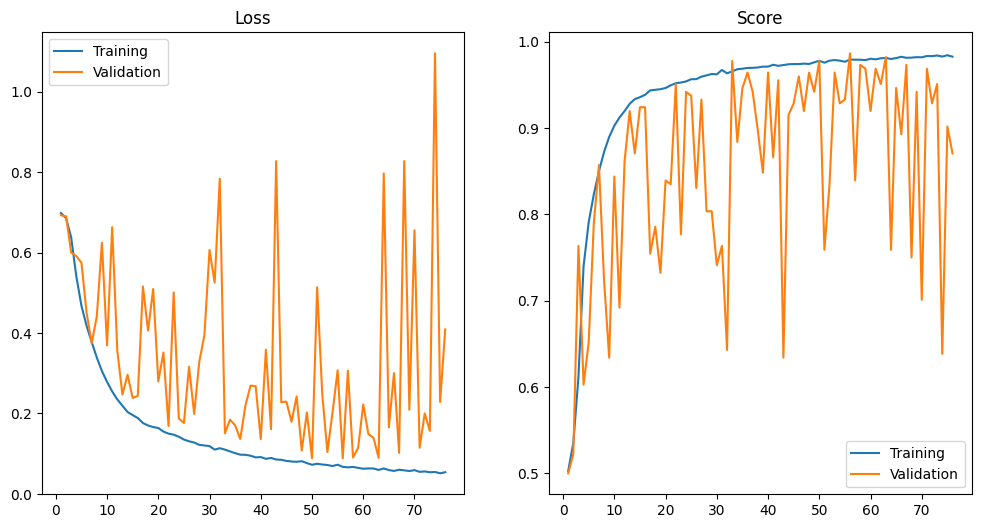

In [26]:
from scripts.utils import plot_train_history

if TRAIN:
    plot_train_history(history)

In [27]:
def get_output_layer_features(model: SimpleNN, u: torch.Tensor) -> torch.Tensor:
    return model.hidden(model.input(u)).detach()

def get_output_layer_feature_matrix(model: SimpleNN, U: torch.Tensor) -> torch.Tensor:
    return torch.cat([get_output_layer_features(model, u).reshape(1, -1) for u in U])

In [28]:
def get_min_dists_inds(x: torch.Tensor, Y: torch.Tensor, labels: torch.Tensor, k: int = 10):
    dists = ((x.reshape(1, -1) - Y)**2).sum(dim=1).sort()
    top_inds = dists[1][:k]
    top_dists = dists[0][:k]
    top_classes = torch.tensor([labels[ind].squeeze() for ind in top_inds])
    return torch.cat([top_dists.reshape(-1, 1), top_classes.reshape(-1, 1)], dim=1)

def get_all_min_dists_inds(X: torch.Tensor, Y: torch.Tensor, labels: torch.Tensor, k: int = 10):
    return torch.cat([get_min_dists_inds(x, Y, labels, k).unsqueeze(0) for x in X])

In [43]:
from scripts.ntk import get_ntk_feature_matrix

def plot_closest_distances(
    model_index: int = -1,
    k: int = 10
) -> None:
    model = history['models'][model_index]

    top_dists_eucl_0, top_dists_eucl_1 = get_all_min_dists_inds(X_empty_0, X_train, Y_train, k), get_all_min_dists_inds(X_empty_1, X_train, Y_train, k)

    top_dists_last_0, top_dists_last_1 = get_all_min_dists_inds(get_output_layer_feature_matrix(model, X_empty_0), get_output_layer_feature_matrix(model, X_train), Y_train, k), get_all_min_dists_inds(get_output_layer_feature_matrix(model, X_empty_1), get_output_layer_feature_matrix(model, X_train), Y_train, k)

    top_dists_grad_0, top_dists_grad_1 = get_all_min_dists_inds(get_ntk_feature_matrix(X_empty_0, model), get_ntk_feature_matrix(X_train, model), Y_train, k), get_all_min_dists_inds(get_ntk_feature_matrix(X_empty_1, model), get_ntk_feature_matrix(X_train, model), Y_train, k)

    fig, ax = plt.subplots(3, 2, figsize=(20, 20))
    for i in range(TEST_COUNT): 
        ax[0][0].scatter(i*torch.ones(k), top_dists_eucl_0[i][:, 0], c=top_dists_eucl_0[i][:, 1], cmap='RdYlGn', s=10, alpha=0.4)
        ax[0][0].set_title('Eucl, neg')
    for i in range(TEST_COUNT):
        ax[0][1].scatter(i*torch.ones(k), top_dists_eucl_1[i][:, 0], c=top_dists_eucl_1[i][:, 1], cmap='RdYlGn', s=10, alpha=0.4)
        ax[0][1].set_title('Eucl, pos')
    for i in range(TEST_COUNT):
        ax[1][0].scatter(i*torch.ones(k), top_dists_last_0[i][:, 0], c=top_dists_last_0[i][:, 1], cmap='RdYlGn', s=10, alpha=0.4)
        ax[1][0].set_title('Last, neg')
    for i in range(TEST_COUNT):
        ax[1][1].scatter(i*torch.ones(k), top_dists_last_1[i][:, 0], c=top_dists_last_1[i][:, 1], cmap='RdYlGn', s=10, alpha=0.4)
        ax[1][1].set_title('Last, pos')
    for i in range(TEST_COUNT):
        ax[2][0].scatter(i*torch.ones(k), top_dists_grad_0[i][:, 0], c=top_dists_grad_0[i][:, 1], cmap='RdYlGn', s=10, alpha=0.4)
        ax[2][0].set_title('Grad, neg')
    for i in range(TEST_COUNT):
        ax[2][1].scatter(i*torch.ones(k), top_dists_grad_1[i][:, 0], c=top_dists_grad_1[i][:, 1], cmap='RdYlGn', s=10, alpha=0.4)
        ax[2][1].set_title('Grad, pos')

    plt.suptitle(f'Epoch {model_index}, red: neg, green: pos')
    plt.show()

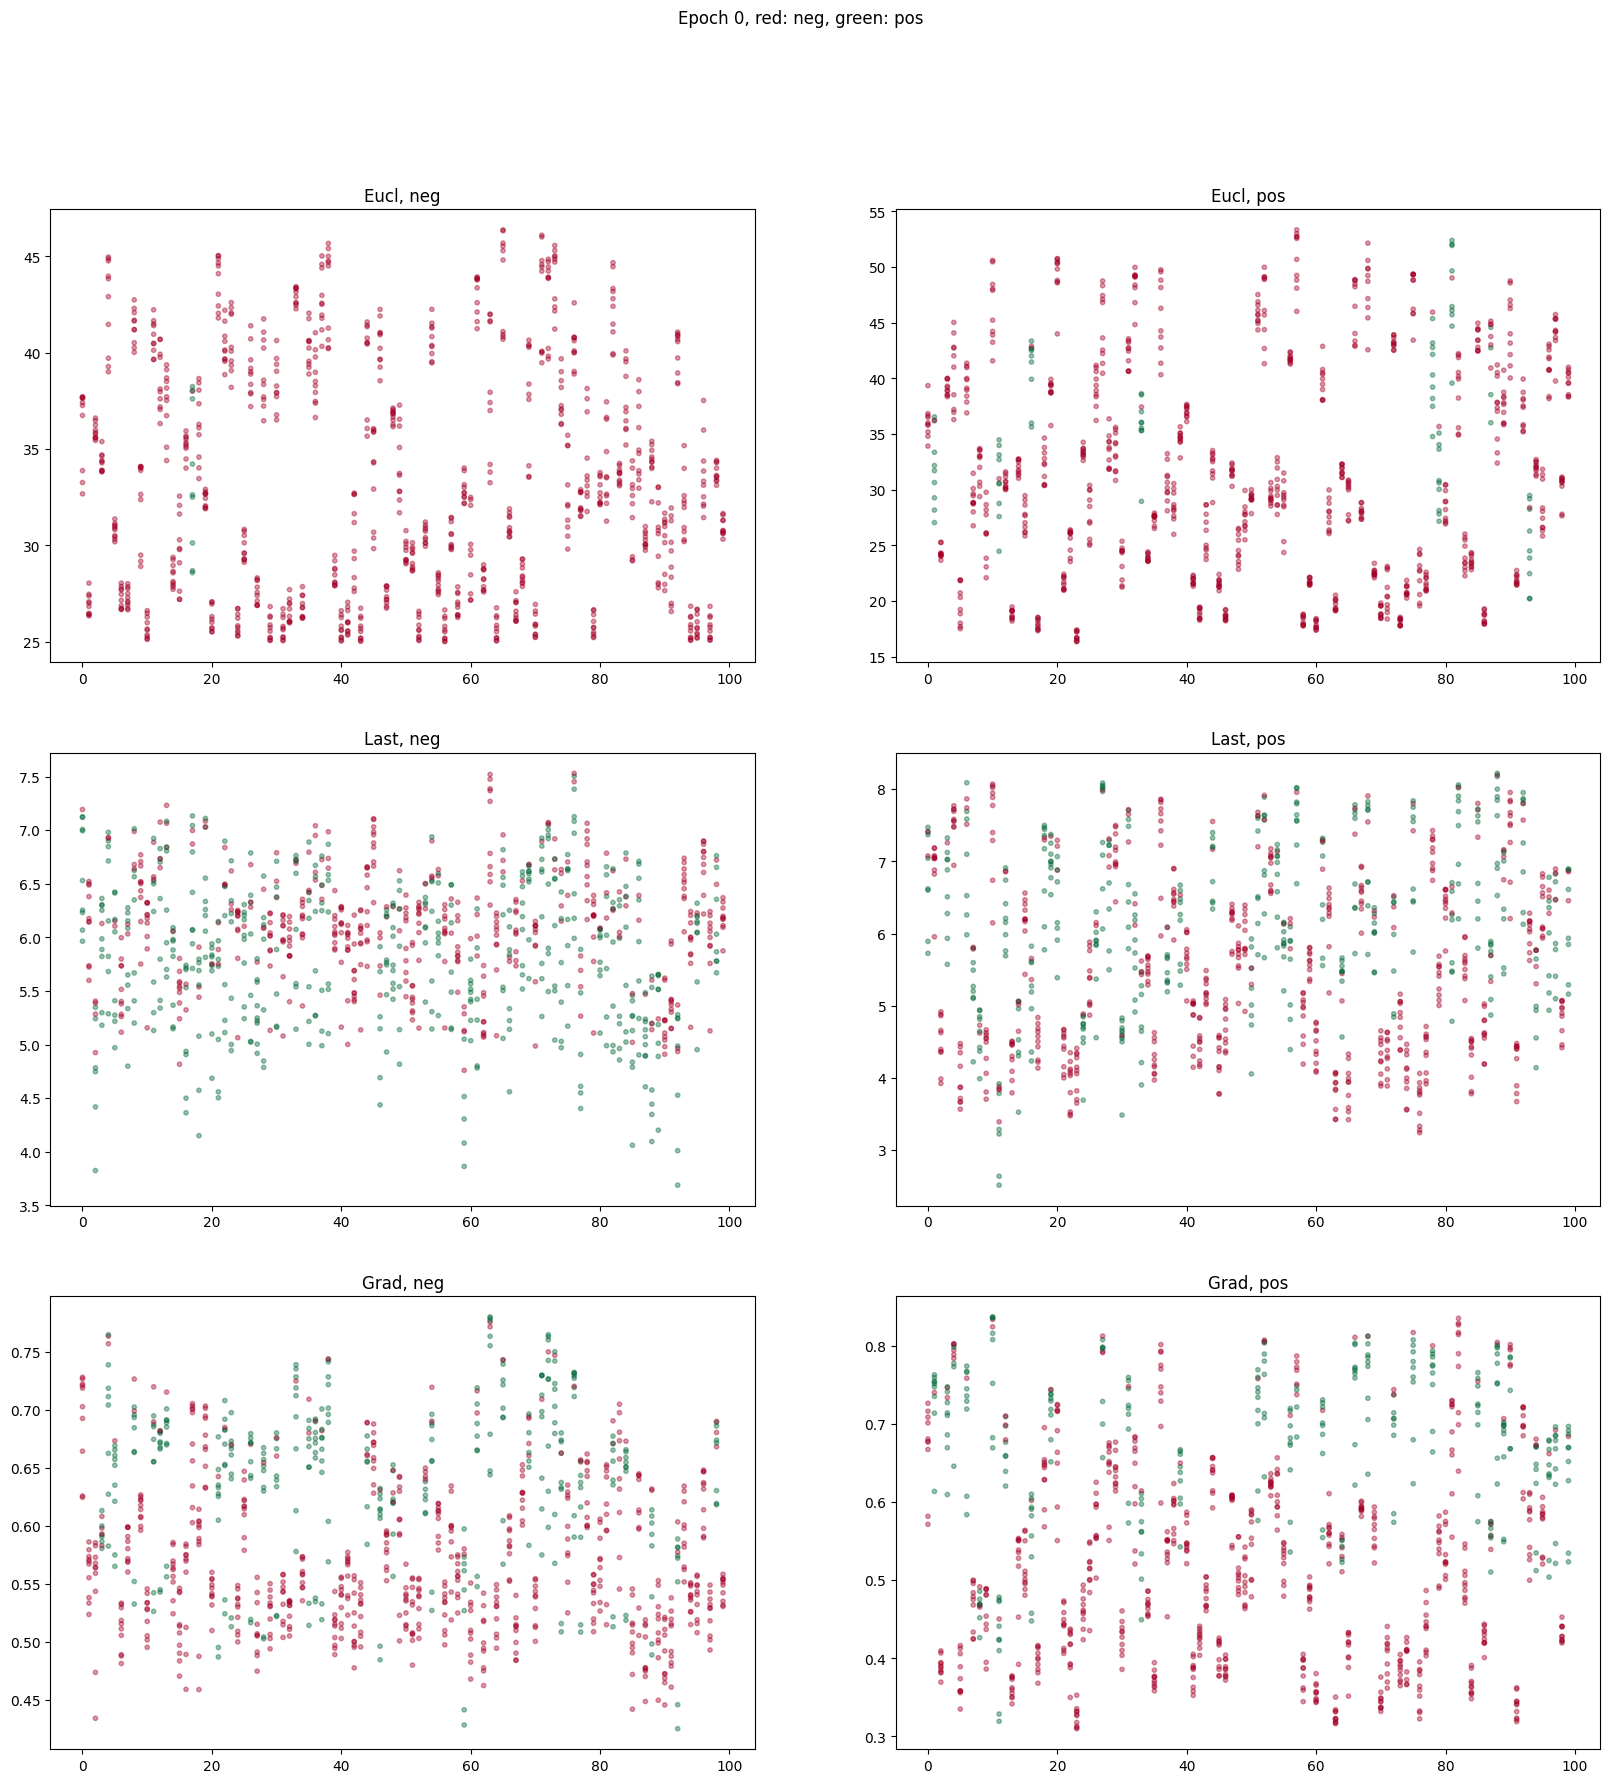

In [44]:
plot_closest_distances(0, 10)

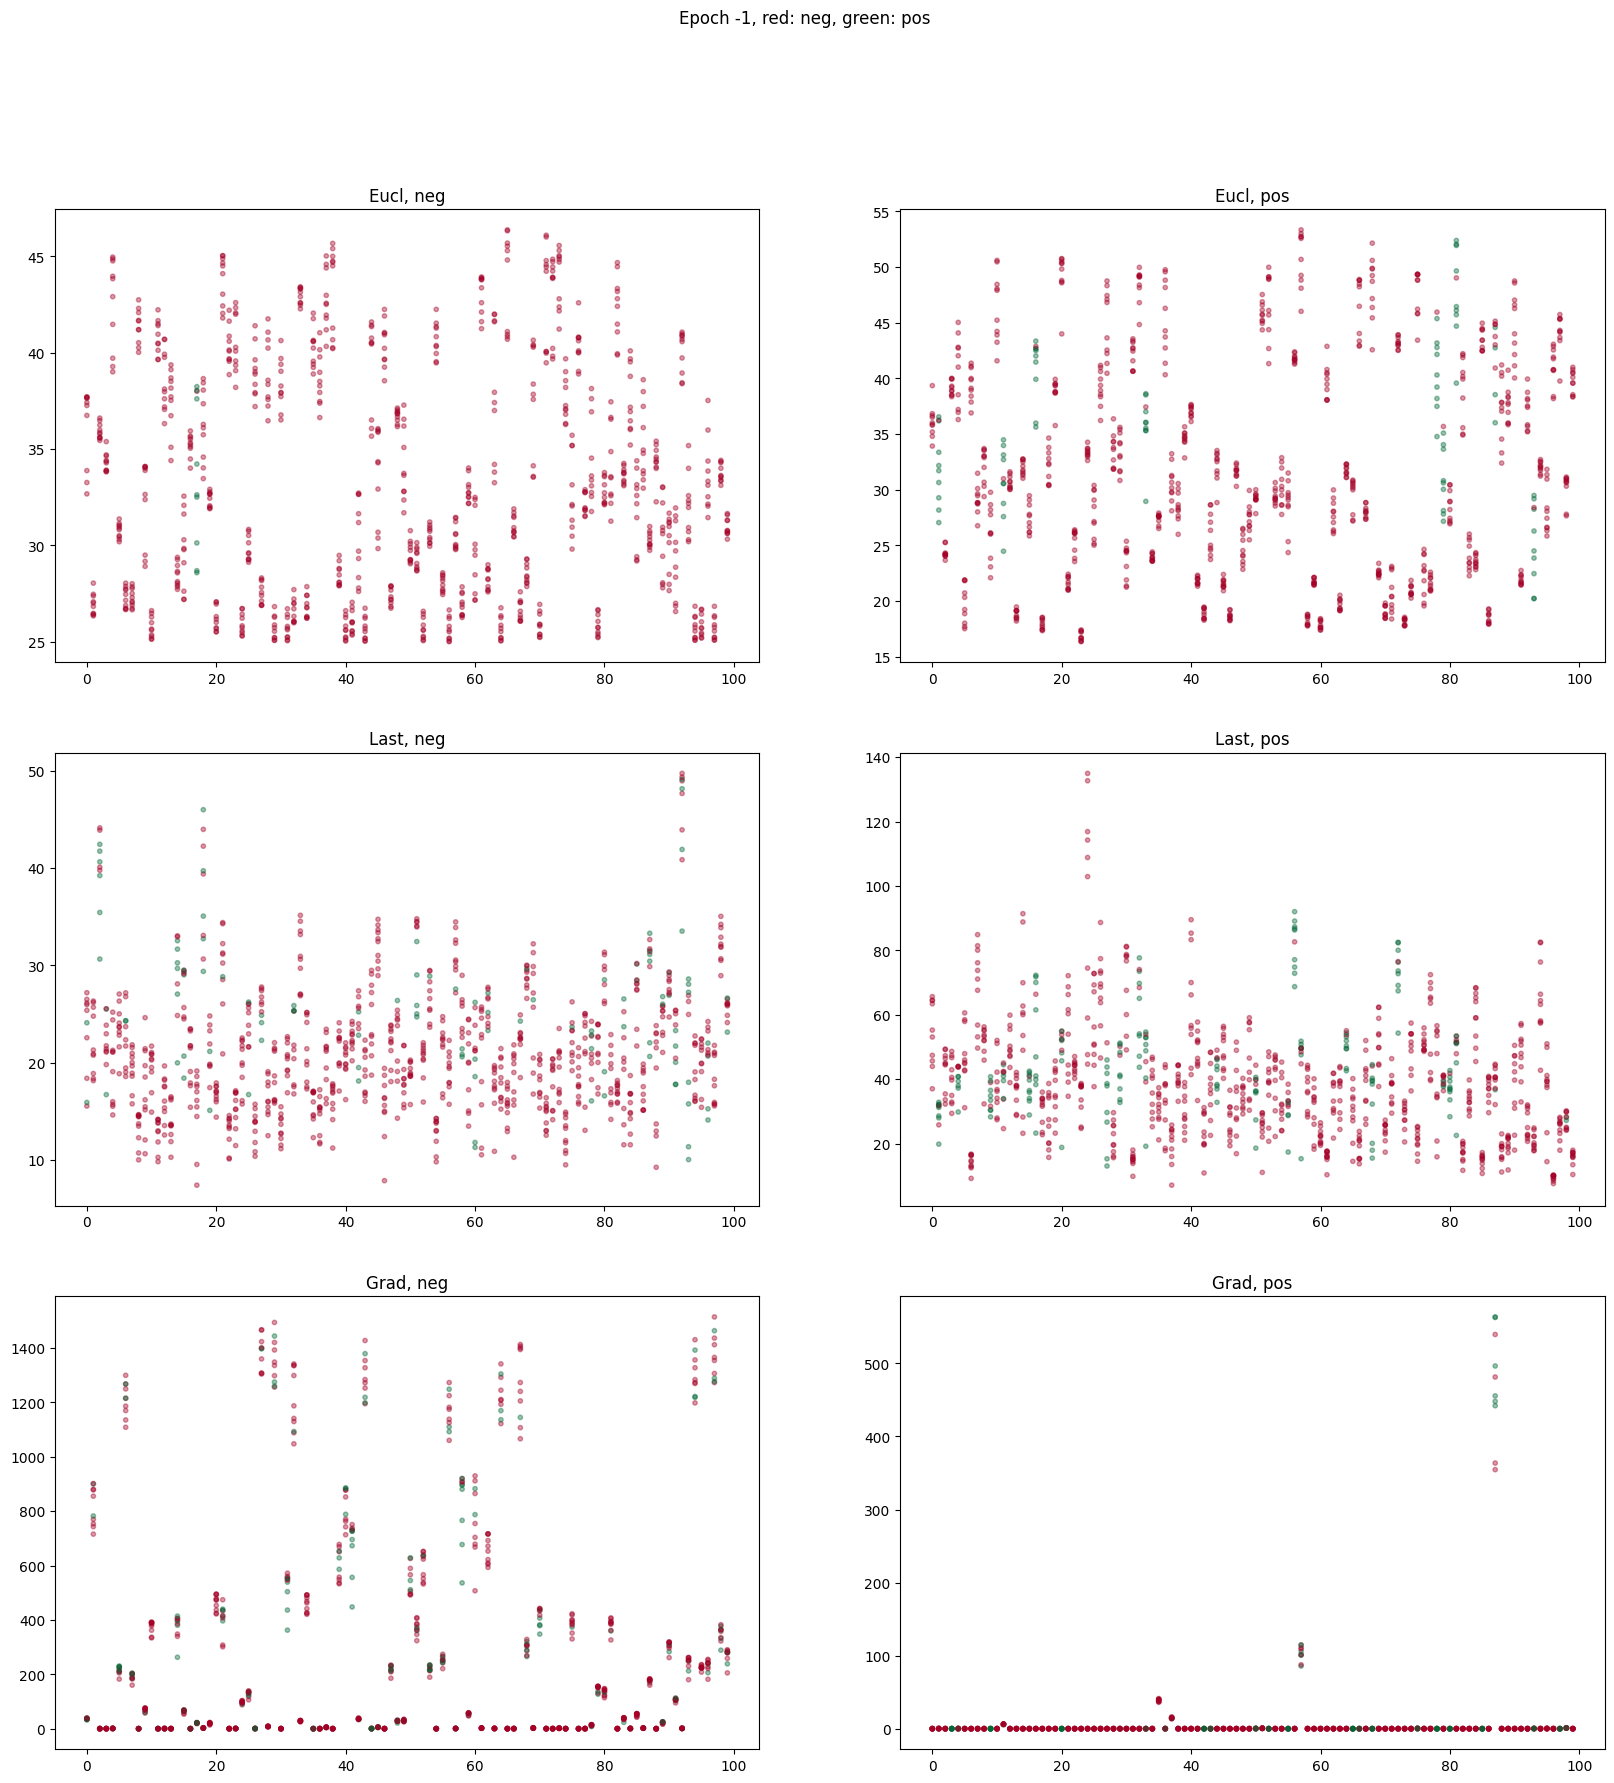

In [33]:
plot_closest_distances(-1, 10)

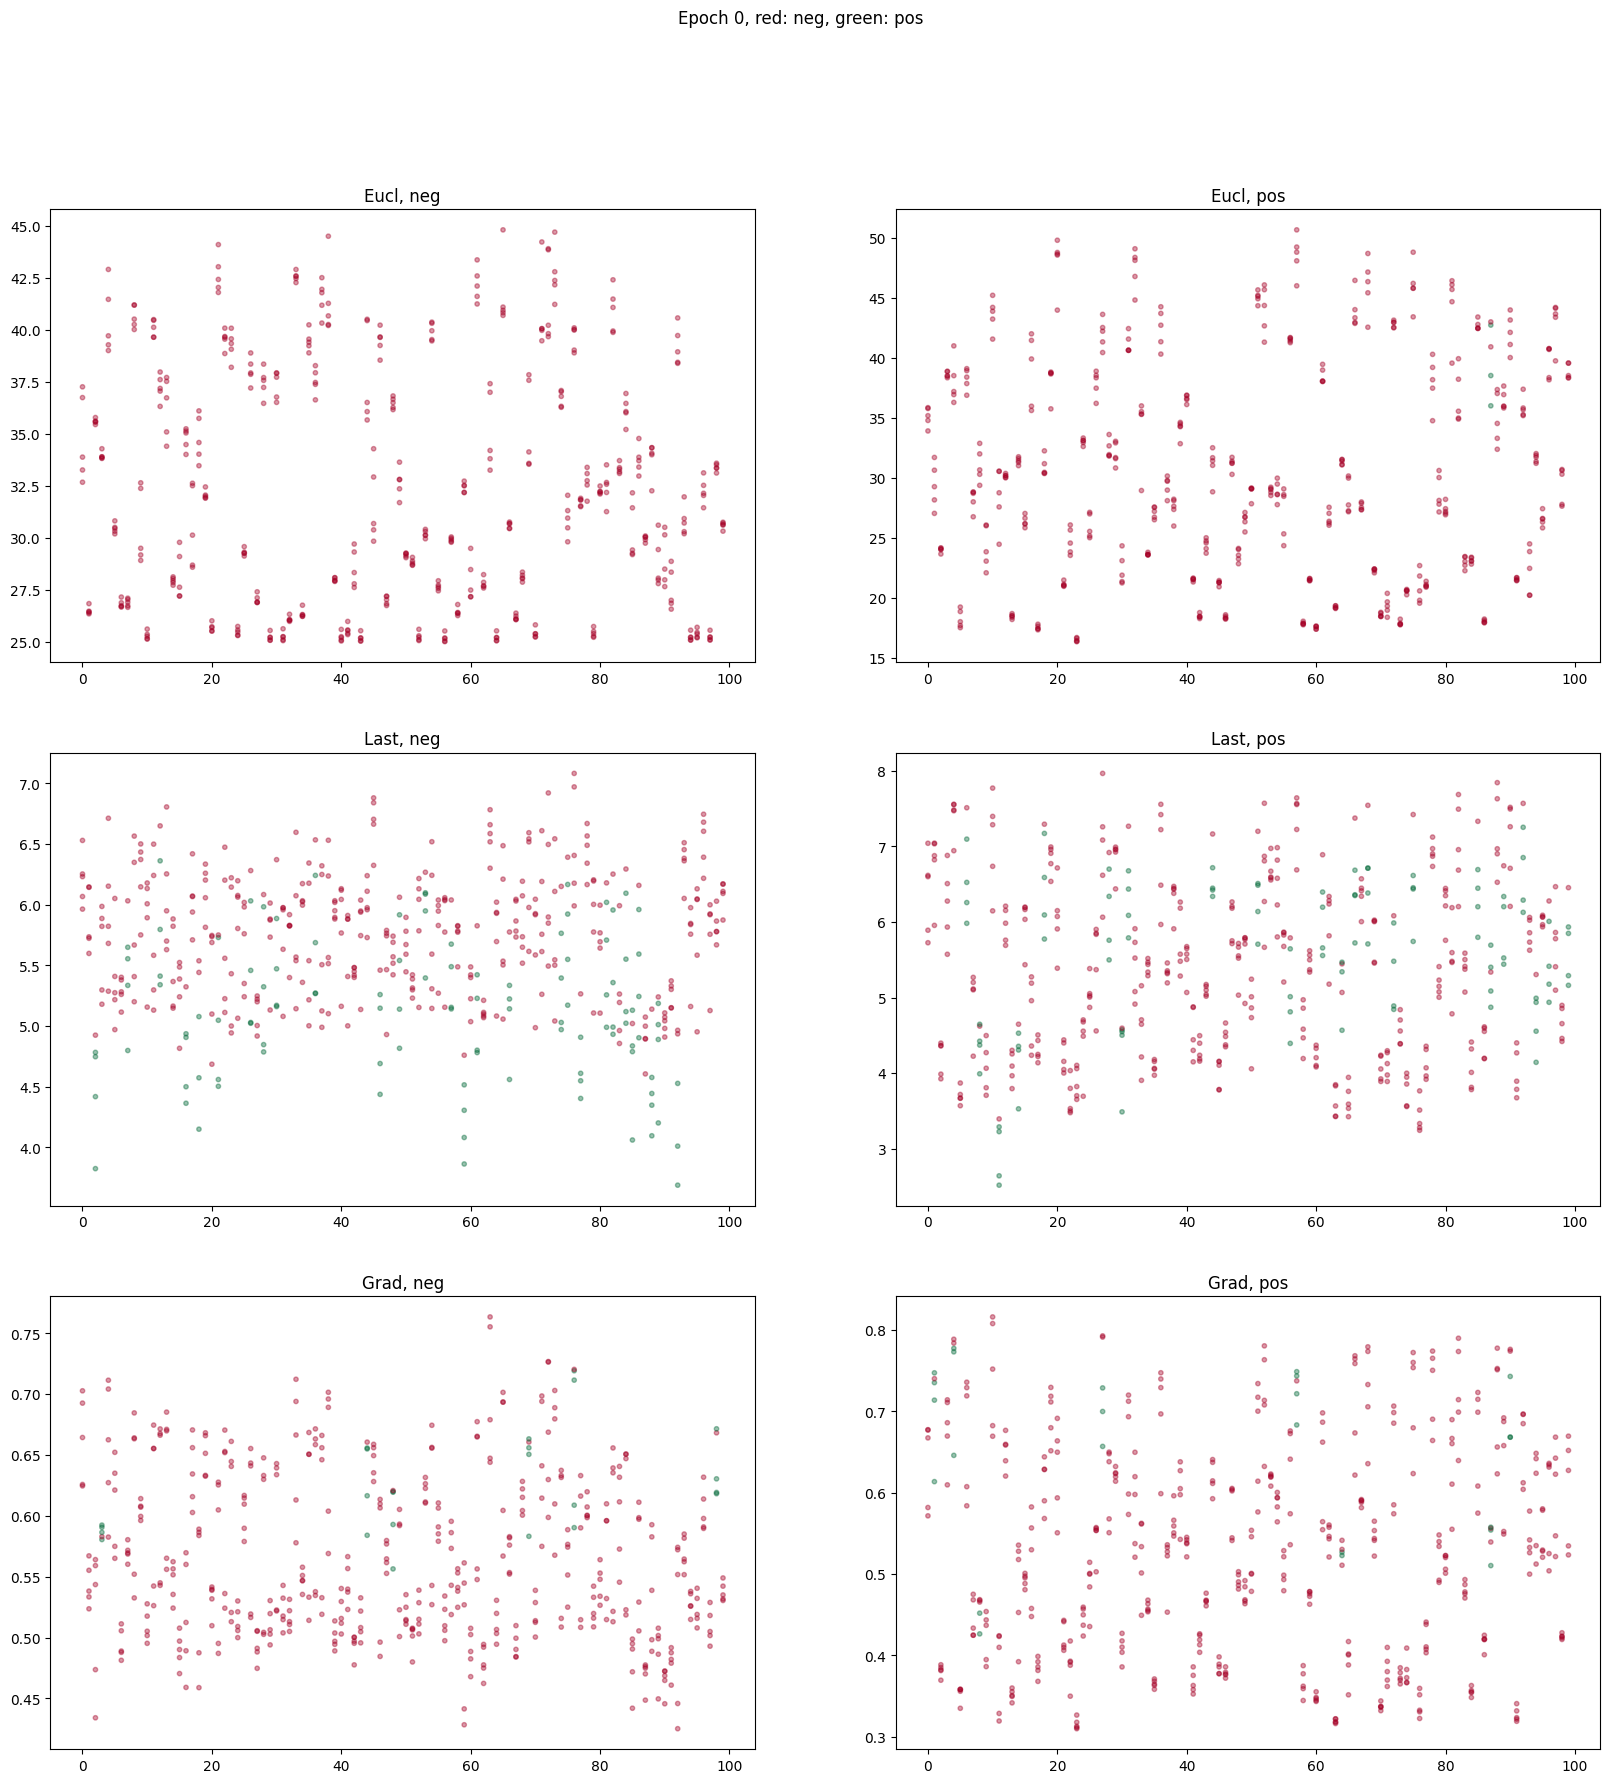

In [34]:
plot_closest_distances(0, 5)

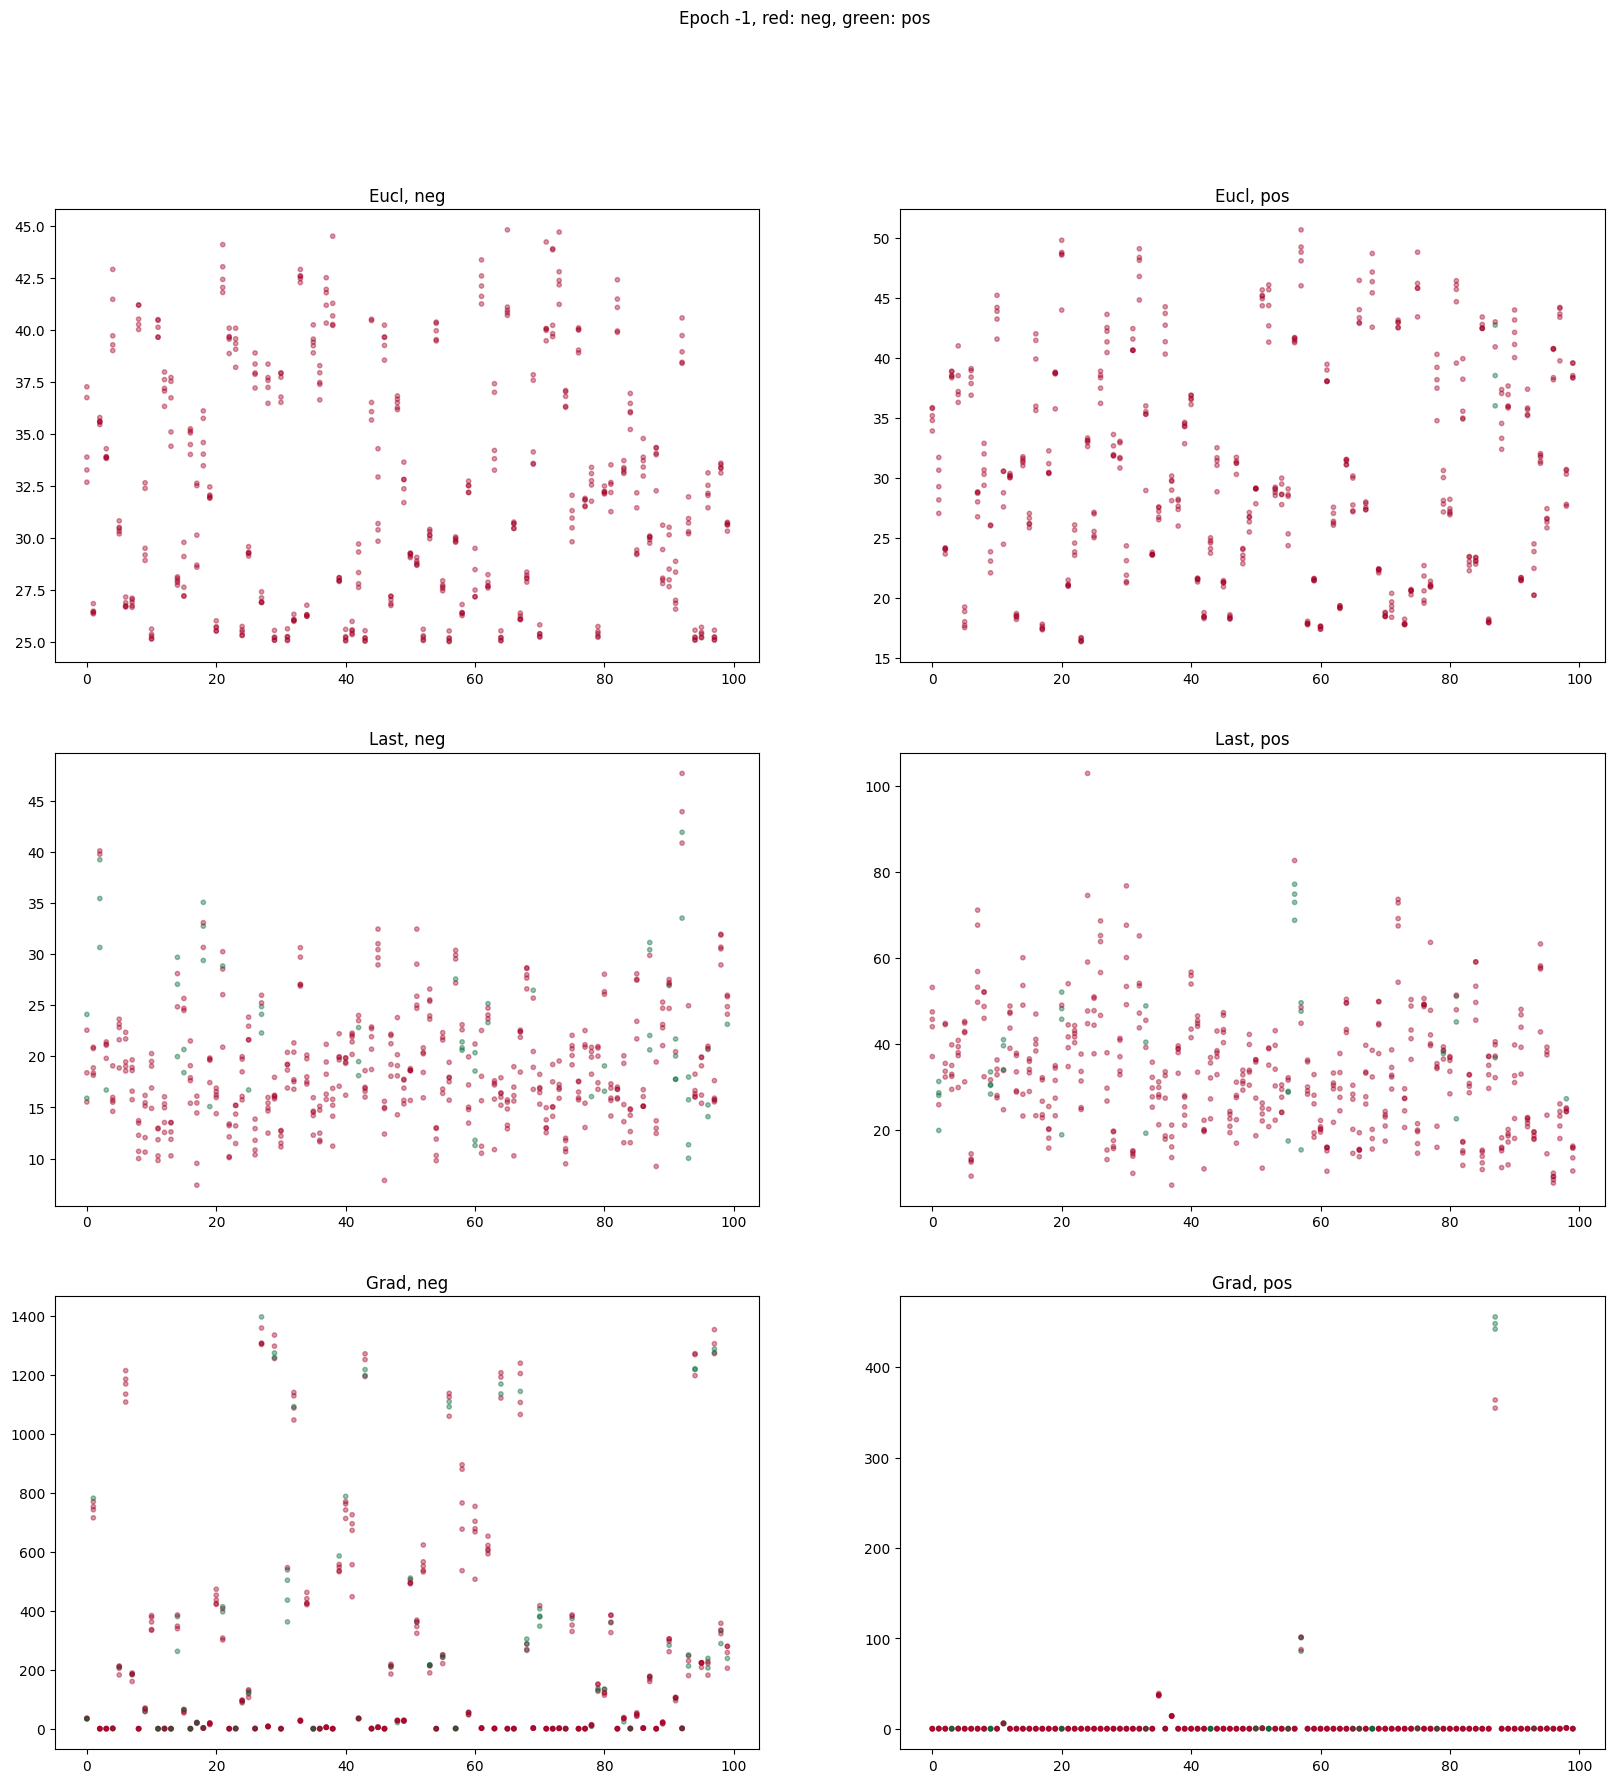

In [35]:
plot_closest_distances(-1, 5)

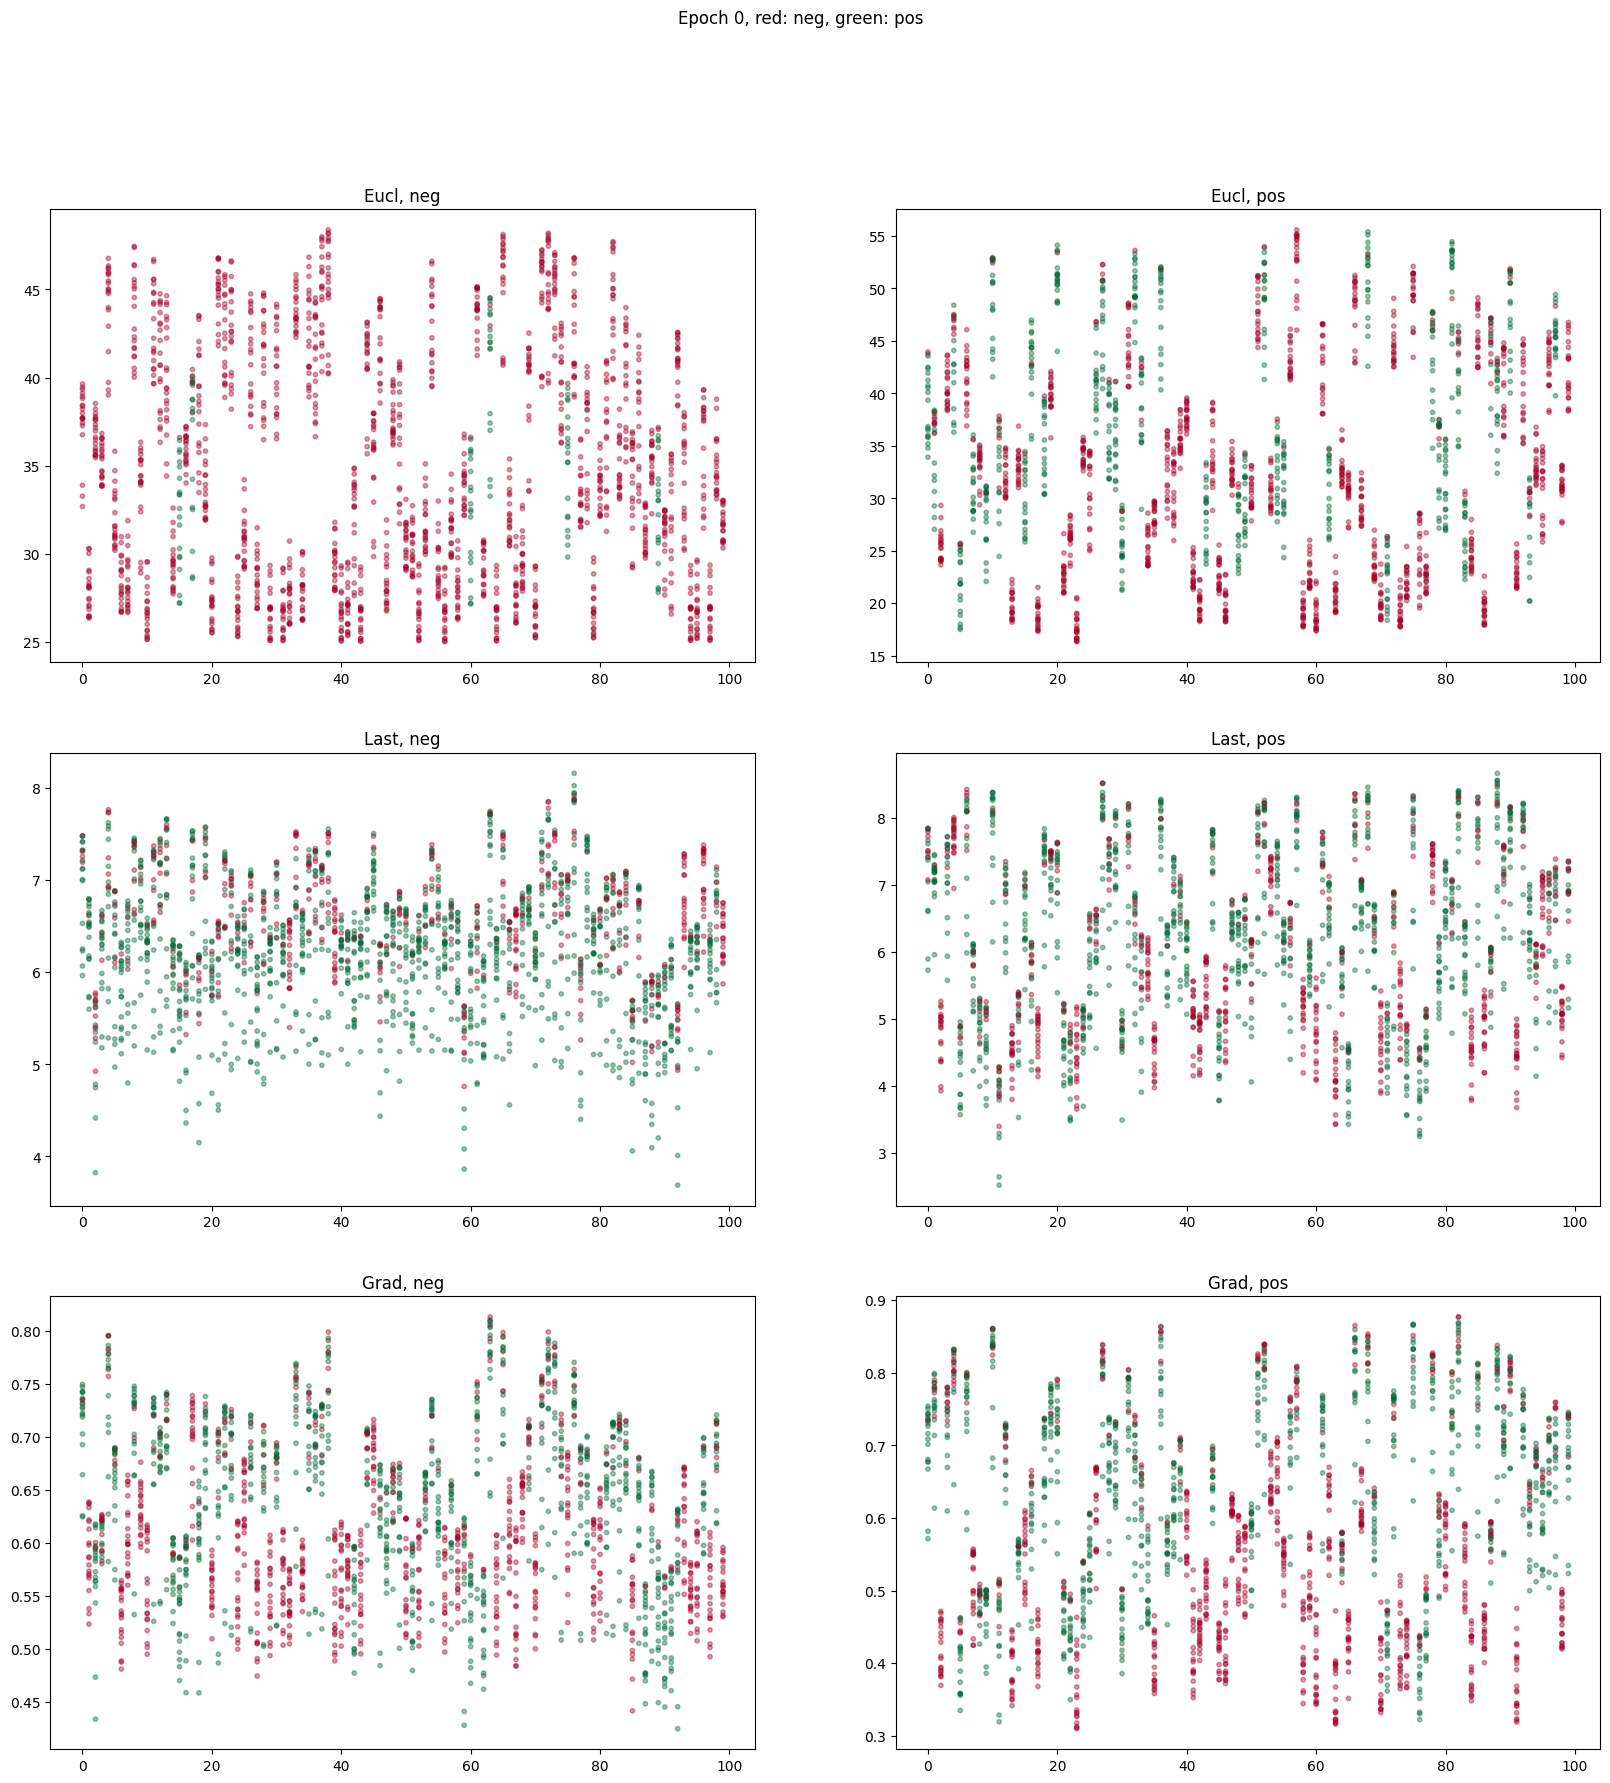

In [36]:
plot_closest_distances(0, 20)

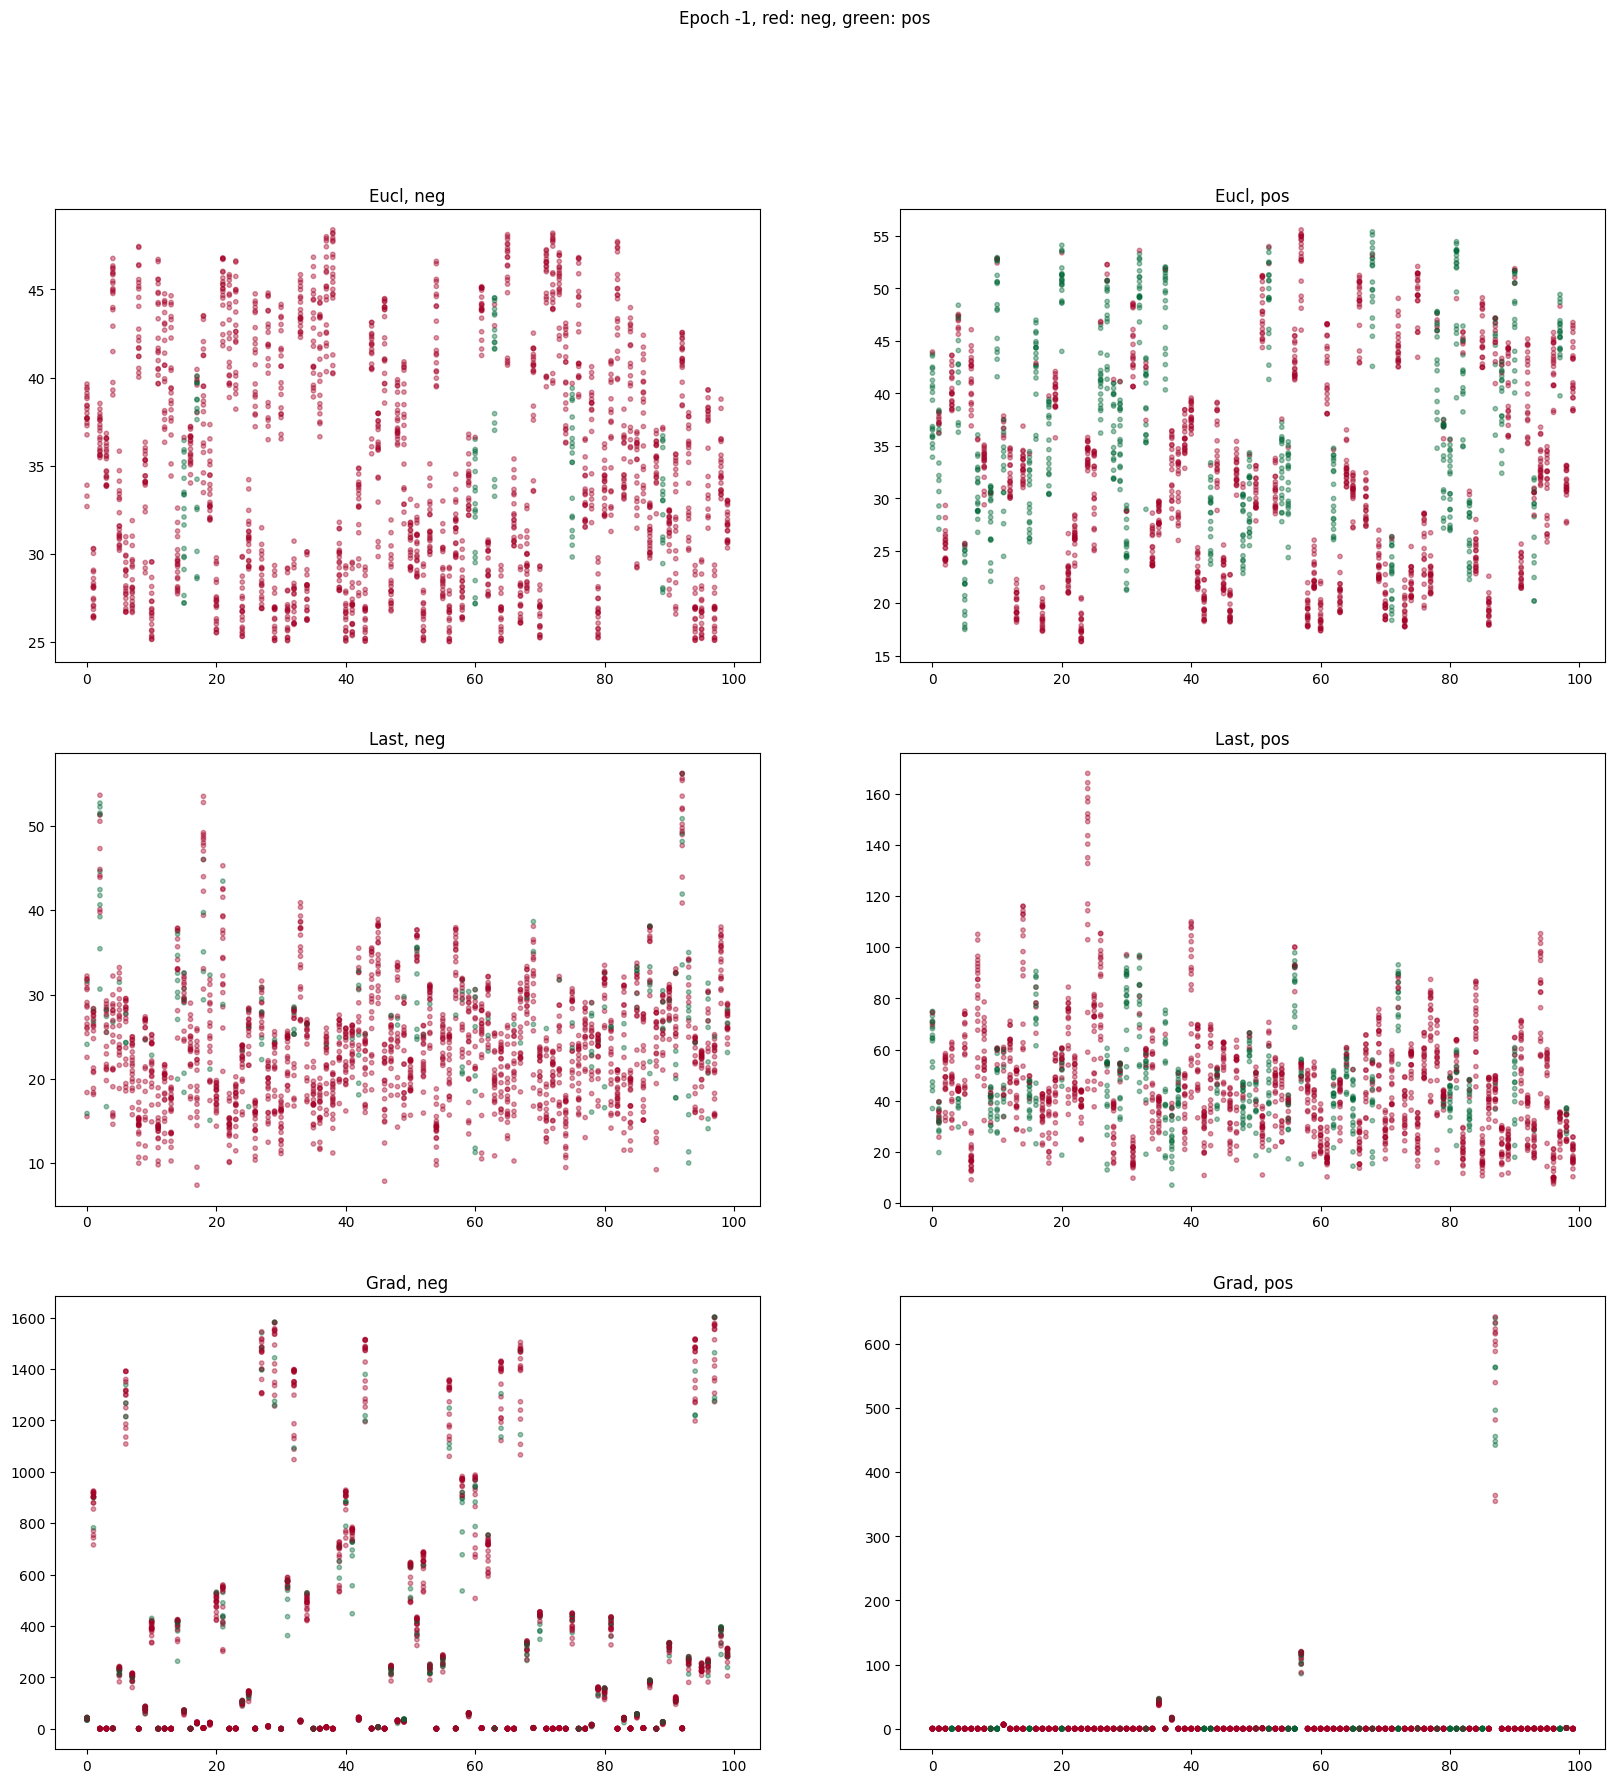

In [37]:
plot_closest_distances(-1, 20)

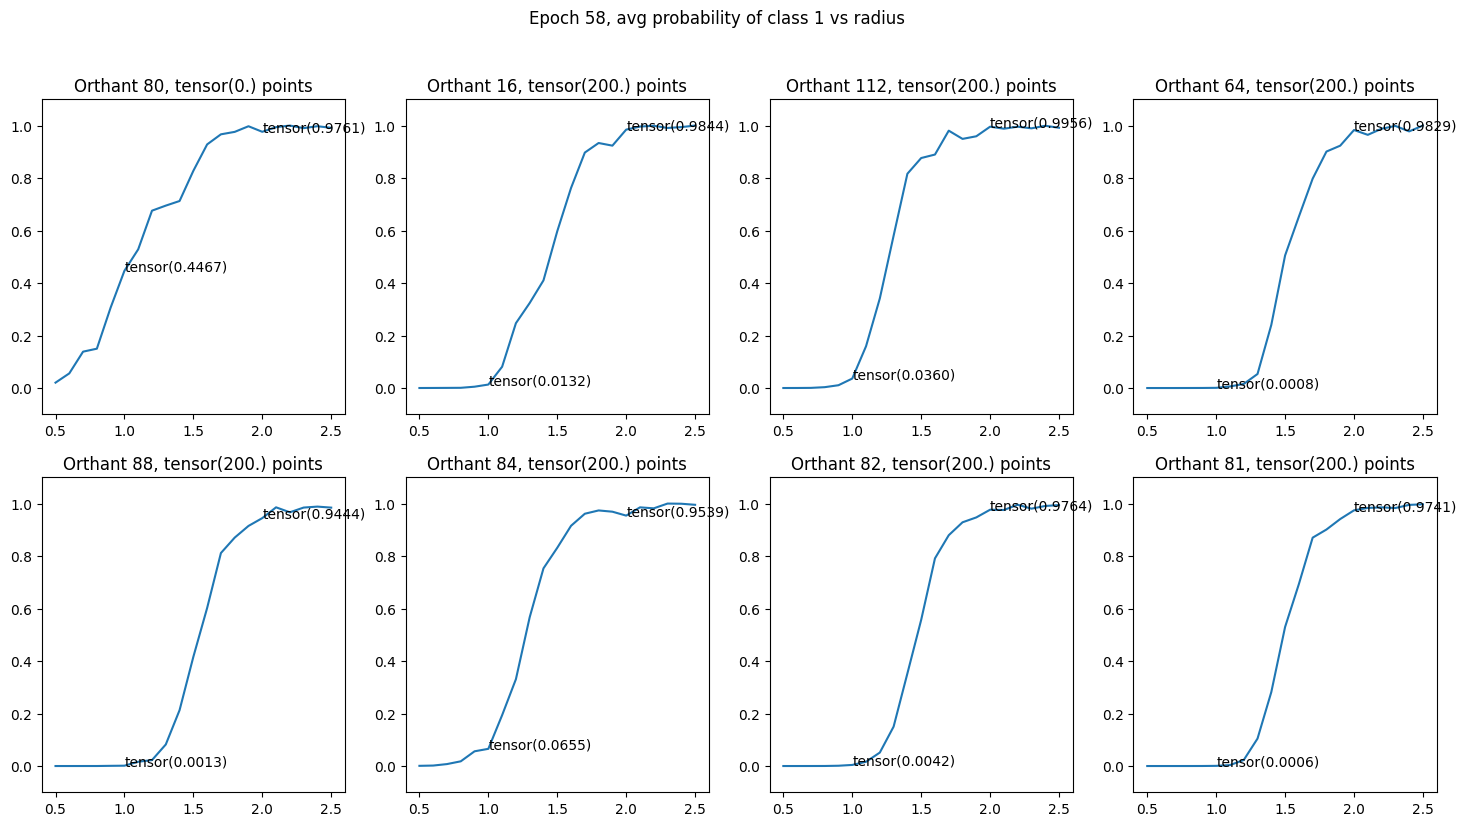

In [30]:
from scripts.utils import plot_radial_visualization

if TRAIN:
    plot_radial_visualization(
        models=history['models'],
        mp4_save_file_name='radial_1empty',
        orthant_counts=orthant_counts,
        main_orthant=ZERO_ORTHANT_INDEX,
        fps=4
    )

In [31]:
from scripts.test import predict

scores_nn = torch.tensor([
    metric(
        predict(best_model_nn, X_test[i], device),
        Y_test[i]
    ) for i in range(128)
])

In [32]:
scores_nn.mean(), scores_nn[ZERO_ORTHANT_INDEX].mean()

(tensor(0.9840), tensor(0.7900))

## SVM

In [33]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
from scripts.ntk import NTK
from sklearn.model_selection import GridSearchCV

In [34]:
ntk = NTK(best_model_nn).get_ntk

In [45]:
model_base_ntk = SVC(kernel=ntk, max_iter=int(1e4))
params_ntk = {
    'C': np.logspace(-5, 5, 11)
}
best_params_ntk = {
    'C': None,
    'score': -np.inf
}

gammas = np.logspace(-5, 5, 11).tolist()
gammas.append('scale')
gammas.append('auto')
model_base_rbf = SVC(kernel='rbf', max_iter=int(1e4))
params_rbf = {
    'C': np.logspace(-5, 5, 11),
    'gamma': gammas
}
best_params_rbf = {
    'C': None,
    'gamma': None,
    'score': -np.inf
}

scorer = make_scorer(accuracy_score)

In [46]:
if VALIDATE_SVM:
    total_count = len(params_ntk['C'])
    curr_count = 0
    print(f'Cross-validating across {total_count} models.')
    for C in params_ntk['C']:
        curr_count += 1
        model_cv_ntk = SVC(kernel=ntk, C=C, max_iter=int(1e4))
        model_cv_ntk.fit(X_train, Y_train.squeeze())
        preds_train, preds_val = model_cv_ntk.predict(X_train), model_cv_ntk.predict(X_val)
        score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
        if score_val > best_params_ntk['score']:
            best_params_ntk['C'] = C
            best_params_ntk['score'] = score_val
        print(f'[{curr_count}/{total_count}]\tC:{C}, train score:{score_train}, val score:{score_val}')
    print(f"\nBest validation accuracy: {best_params_ntk['score']}, for C = {best_params_ntk['C']}")

Cross-validating across 11 models.


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[1/11]	C:1e-05, train score:0.5023622047244094, val score:0.52


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[2/11]	C:0.0001, train score:0.5023622047244094, val score:0.52


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[3/11]	C:0.001, train score:0.5023622047244094, val score:0.52


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[4/11]	C:0.01, train score:0.5028346456692914, val score:0.52


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[5/11]	C:0.1, train score:0.5117716535433071, val score:0.67


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[6/11]	C:1.0, train score:0.535, val score:0.72


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[7/11]	C:10.0, train score:0.5196062992125984, val score:0.65


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[8/11]	C:100.0, train score:0.5326771653543307, val score:0.74


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[9/11]	C:1000.0, train score:0.567244094488189, val score:0.685


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[10/11]	C:10000.0, train score:0.5590551181102362, val score:0.725


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[11/11]	C:100000.0, train score:0.6001968503937007, val score:0.615

Best validation accuracy: 0.74, for C = 100.0


In [47]:
if VALIDATE_SVM:
    total_count = len(params_rbf['C']) * len(params_rbf['gamma'])
    curr_count = 0
    print(f'Cross-validating across {total_count} models.')
    for C in params_rbf['C']:
        for gamma in params_rbf['gamma']:
            curr_count += 1
            model_cv_rbf = SVC(kernel='rbf', C=C, gamma=gamma, max_iter=int(1e4))
            model_cv_rbf.fit(X_train, Y_train.squeeze())
            preds_train, preds_val = model_cv_rbf.predict(X_train), model_cv_rbf.predict(X_val)
            score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
            if score_val > best_params_rbf['score']:
                best_params_rbf['C'] = C
                best_params_rbf['gamma'] = gamma
                best_params_rbf['score'] = score_val
            print(f'[{curr_count}/{total_count}]\tC:{C}, gamma:{gamma}, train score:{score_train}, val score:{score_val}')
    print(f"\nBest validation accuracy: {best_params_rbf['score']}, for C = {best_params_rbf['C']}, gamma = {best_params_rbf['gamma']}")

Cross-validating across 143 models.


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[1/143]	C:1e-05, gamma:1e-05, train score:0.43838582677165355, val score:0.335


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[2/143]	C:1e-05, gamma:0.0001, train score:0.4372834645669291, val score:0.335


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[3/143]	C:1e-05, gamma:0.001, train score:0.504763779527559, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[4/143]	C:1e-05, gamma:0.01, train score:0.4739763779527559, val score:0.465


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[5/143]	C:1e-05, gamma:0.1, train score:0.9517716535433071, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[6/143]	C:1e-05, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[7/143]	C:1e-05, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[8/143]	C:1e-05, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[9/143]	C:1e-05, gamma:1000.0, train score:0.960236220472441, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[10/143]	C:1e-05, gamma:10000.0, train score:0.9043700787401575, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[11/143]	C:1e-05, gamma:100000.0, train score:0.8951968503937008, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[12/143]	C:1e-05, gamma:scale, train score:0.4671259842519685, val score:0.46


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[13/143]	C:1e-05, gamma:auto, train score:0.9954724409448819, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[14/143]	C:0.0001, gamma:1e-05, train score:0.44448818897637793, val score:0.34


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[15/143]	C:0.0001, gamma:0.0001, train score:0.4372834645669291, val score:0.335


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[16/143]	C:0.0001, gamma:0.001, train score:0.5112204724409449, val score:0.49


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[17/143]	C:0.0001, gamma:0.01, train score:0.4732677165354331, val score:0.465


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[18/143]	C:0.0001, gamma:0.1, train score:0.9514173228346456, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[19/143]	C:0.0001, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[20/143]	C:0.0001, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[21/143]	C:0.0001, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[22/143]	C:0.0001, gamma:1000.0, train score:0.9645669291338582, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[23/143]	C:0.0001, gamma:10000.0, train score:0.9051181102362205, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[24/143]	C:0.0001, gamma:100000.0, train score:0.8952755905511811, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[25/143]	C:0.0001, gamma:scale, train score:0.46496062992125986, val score:0.465


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[26/143]	C:0.0001, gamma:auto, train score:0.9954724409448819, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[27/143]	C:0.001, gamma:1e-05, train score:0.44448818897637793, val score:0.34


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[28/143]	C:0.001, gamma:0.0001, train score:0.4407874015748032, val score:0.335


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[29/143]	C:0.001, gamma:0.001, train score:0.5065354330708661, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[30/143]	C:0.001, gamma:0.01, train score:0.47334645669291336, val score:0.475


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[31/143]	C:0.001, gamma:0.1, train score:0.942007874015748, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[32/143]	C:0.001, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[33/143]	C:0.001, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[34/143]	C:0.001, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[35/143]	C:0.001, gamma:1000.0, train score:0.968503937007874, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[36/143]	C:0.001, gamma:10000.0, train score:0.9054330708661418, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[37/143]	C:0.001, gamma:100000.0, train score:0.8955118110236221, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[38/143]	C:0.001, gamma:scale, train score:0.46885826771653544, val score:0.485


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[39/143]	C:0.001, gamma:auto, train score:0.9954330708661417, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[40/143]	C:0.01, gamma:1e-05, train score:0.44448818897637793, val score:0.34


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[41/143]	C:0.01, gamma:0.0001, train score:0.4369291338582677, val score:0.325


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[42/143]	C:0.01, gamma:0.001, train score:0.5077952755905512, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[43/143]	C:0.01, gamma:0.01, train score:0.4725984251968504, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[44/143]	C:0.01, gamma:0.1, train score:0.9535039370078741, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[45/143]	C:0.01, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[46/143]	C:0.01, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[47/143]	C:0.01, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[48/143]	C:0.01, gamma:1000.0, train score:0.9724409448818898, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[49/143]	C:0.01, gamma:10000.0, train score:0.9068110236220472, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[50/143]	C:0.01, gamma:100000.0, train score:0.8955511811023622, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[51/143]	C:0.01, gamma:scale, train score:0.4630314960629921, val score:0.465


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[52/143]	C:0.01, gamma:auto, train score:0.9953149606299213, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[53/143]	C:0.1, gamma:1e-05, train score:0.43905511811023623, val score:0.33


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[54/143]	C:0.1, gamma:0.0001, train score:0.43901574803149607, val score:0.335


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[55/143]	C:0.1, gamma:0.001, train score:0.4816535433070866, val score:0.455


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[56/143]	C:0.1, gamma:0.01, train score:0.49984251968503934, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[57/143]	C:0.1, gamma:0.1, train score:0.9803149606299213, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[58/143]	C:0.1, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[59/143]	C:0.1, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[60/143]	C:0.1, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[61/143]	C:0.1, gamma:1000.0, train score:0.9763385826771653, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[62/143]	C:0.1, gamma:10000.0, train score:0.9079527559055118, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[63/143]	C:0.1, gamma:100000.0, train score:0.8957086614173229, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[64/143]	C:0.1, gamma:scale, train score:0.49145669291338584, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[65/143]	C:0.1, gamma:auto, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[66/143]	C:1.0, gamma:1e-05, train score:0.4432283464566929, val score:0.34


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[67/143]	C:1.0, gamma:0.0001, train score:0.47562992125984255, val score:0.455


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[68/143]	C:1.0, gamma:0.001, train score:0.49866141732283464, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[69/143]	C:1.0, gamma:0.01, train score:0.568228346456693, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[70/143]	C:1.0, gamma:0.1, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[71/143]	C:1.0, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[72/143]	C:1.0, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[73/143]	C:1.0, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[74/143]	C:1.0, gamma:1000.0, train score:0.9818897637795275, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[75/143]	C:1.0, gamma:10000.0, train score:0.9081889763779527, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[76/143]	C:1.0, gamma:100000.0, train score:0.8958267716535433, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[77/143]	C:1.0, gamma:scale, train score:0.5198031496062993, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[78/143]	C:1.0, gamma:auto, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[79/143]	C:10.0, gamma:1e-05, train score:0.4541338582677165, val score:0.405


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[80/143]	C:10.0, gamma:0.0001, train score:0.5068897637795275, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[81/143]	C:10.0, gamma:0.001, train score:0.5011023622047244, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[82/143]	C:10.0, gamma:0.01, train score:0.8566929133858268, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[83/143]	C:10.0, gamma:0.1, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[84/143]	C:10.0, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[85/143]	C:10.0, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[86/143]	C:10.0, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[87/143]	C:10.0, gamma:1000.0, train score:0.9183070866141733, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[88/143]	C:10.0, gamma:10000.0, train score:0.907244094488189, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[89/143]	C:10.0, gamma:100000.0, train score:0.895748031496063, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[90/143]	C:10.0, gamma:scale, train score:0.7815748031496063, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[91/143]	C:10.0, gamma:auto, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[92/143]	C:100.0, gamma:1e-05, train score:0.5053543307086614, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[93/143]	C:100.0, gamma:0.0001, train score:0.5098425196850394, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[94/143]	C:100.0, gamma:0.001, train score:0.5030708661417322, val score:0.395


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[95/143]	C:100.0, gamma:0.01, train score:0.882755905511811, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[96/143]	C:100.0, gamma:0.1, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[97/143]	C:100.0, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[98/143]	C:100.0, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[99/143]	C:100.0, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[100/143]	C:100.0, gamma:1000.0, train score:0.9183070866141733, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[101/143]	C:100.0, gamma:10000.0, train score:0.907244094488189, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[102/143]	C:100.0, gamma:100000.0, train score:0.895748031496063, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[103/143]	C:100.0, gamma:scale, train score:0.8297637795275591, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[104/143]	C:100.0, gamma:auto, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[105/143]	C:1000.0, gamma:1e-05, train score:0.49696850393700787, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[106/143]	C:1000.0, gamma:0.0001, train score:0.4925984251968504, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[107/143]	C:1000.0, gamma:0.001, train score:0.5002755905511811, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[108/143]	C:1000.0, gamma:0.01, train score:0.8989370078740158, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[109/143]	C:1000.0, gamma:0.1, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[110/143]	C:1000.0, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[111/143]	C:1000.0, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[112/143]	C:1000.0, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[113/143]	C:1000.0, gamma:1000.0, train score:0.9183070866141733, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[114/143]	C:1000.0, gamma:10000.0, train score:0.907244094488189, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[115/143]	C:1000.0, gamma:100000.0, train score:0.895748031496063, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[116/143]	C:1000.0, gamma:scale, train score:0.7315748031496063, val score:0.525


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[117/143]	C:1000.0, gamma:auto, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[118/143]	C:10000.0, gamma:1e-05, train score:0.4905511811023622, val score:0.315


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[119/143]	C:10000.0, gamma:0.0001, train score:0.49913385826771656, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[120/143]	C:10000.0, gamma:0.001, train score:0.49350393700787404, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[121/143]	C:10000.0, gamma:0.01, train score:0.8989370078740158, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[122/143]	C:10000.0, gamma:0.1, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[123/143]	C:10000.0, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[124/143]	C:10000.0, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[125/143]	C:10000.0, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[126/143]	C:10000.0, gamma:1000.0, train score:0.9183070866141733, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[127/143]	C:10000.0, gamma:10000.0, train score:0.907244094488189, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[128/143]	C:10000.0, gamma:100000.0, train score:0.895748031496063, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[129/143]	C:10000.0, gamma:scale, train score:0.7315748031496063, val score:0.525


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[130/143]	C:10000.0, gamma:auto, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[131/143]	C:100000.0, gamma:1e-05, train score:0.4972047244094488, val score:0.54


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[132/143]	C:100000.0, gamma:0.0001, train score:0.48744094488188977, val score:0.525


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[133/143]	C:100000.0, gamma:0.001, train score:0.49350393700787404, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[134/143]	C:100000.0, gamma:0.01, train score:0.8989370078740158, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[135/143]	C:100000.0, gamma:0.1, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[136/143]	C:100000.0, gamma:1.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[137/143]	C:100000.0, gamma:10.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[138/143]	C:100000.0, gamma:100.0, train score:1.0, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[139/143]	C:100000.0, gamma:1000.0, train score:0.9183070866141733, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[140/143]	C:100000.0, gamma:10000.0, train score:0.907244094488189, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[141/143]	C:100000.0, gamma:100000.0, train score:0.895748031496063, val score:0.5


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[142/143]	C:100000.0, gamma:scale, train score:0.7315748031496063, val score:0.525


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[143/143]	C:100000.0, gamma:auto, train score:1.0, val score:0.5

Best validation accuracy: 0.54, for C = 100000.0, gamma = 1e-05


In [48]:
import json

if VALIDATE_SVM:
    if best_params_rbf['score'] >= best_params_ntk['score']:
        best_model_km = SVC(C=best_params_rbf['C'], kernel='rbf', gamma=best_params_rbf['gamma'])
        best_config = {
            'kernel': 'rbf',
            'C': best_params_rbf['C'],
            'gamma': best_params_rbf['gamma']
        }
        with open('configs/svm/orthants-single-empty.json', 'w') as f:
            json.dump(best_config, f)
    else:
        best_model_km = SVC(C=best_params_ntk['C'], kernel=ntk)
        best_config = {
            'kernel': 'ntk',
            'C': best_params_ntk['C']
        }
        with open('configs/svm/orthants-single-empty.json', 'w') as f:
            json.dump(best_config, f)
else:
    with open('configs/svm/orthants-single-empty.json', 'r') as f:
        best_config = json.load(f)
    if best_config['kernel'] == 'rbf':
        best_model_km = SVC(C=best_config['C'], gamma=best_config['gamma'])
    else:
        best_model_km = SVC(kernel=ntk, C=best_config['C'])

In [49]:
best_model_km.fit(X_train, Y_train.squeeze())

SVC(C=100.0,
    kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7f2b05486200>>)

In [50]:
preds_train, preds_val = best_model_km.predict(X_train), best_model_km.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(0.7251968503937007, 0.81)

In [51]:
scores_km = np.array([
    accuracy_score(
        best_model_km.predict(X_test[i]),
        Y_test[i].squeeze()
    ) for i in range(128)
])

In [52]:
scores_km.mean(), scores_km[ZERO_ORTHANT_INDEX].mean()

(0.7069140625, 0.81)

## NN vs SVM

Text(0.5, 0.98, 'Accuracy per orthant')

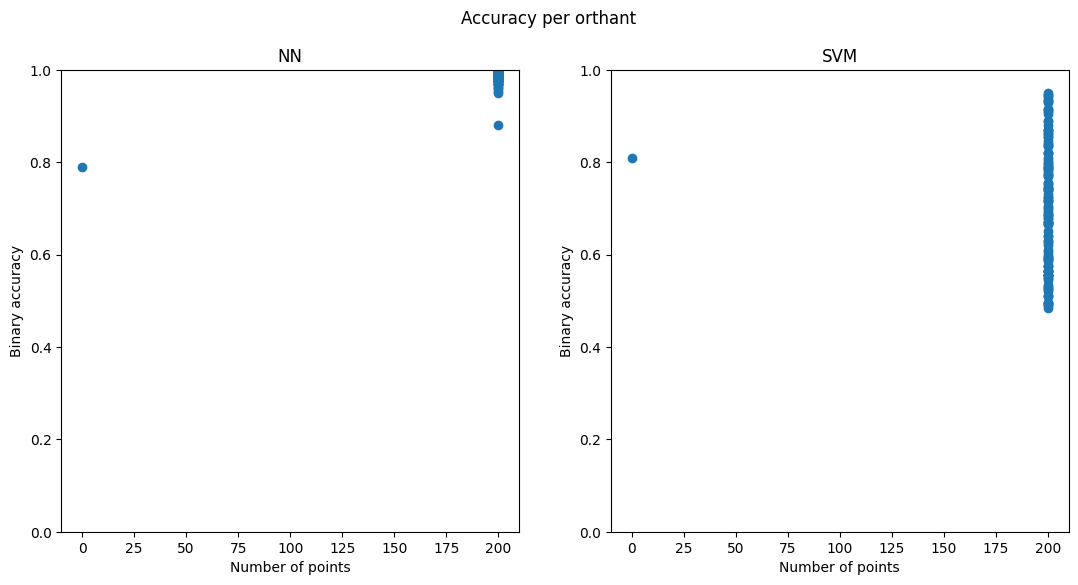

In [53]:
plt.figure(figsize=(13, 6))

# Reproduce when validating on subset of training data (source dbn) also

plt.subplot(121)
plt.scatter(orthant_counts, scores_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('NN')

plt.subplot(122)
plt.scatter(orthant_counts, scores_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('SVM')

plt.suptitle('Accuracy per orthant')

Text(0.5, 0.98, 'Test accuracy vs orthant')

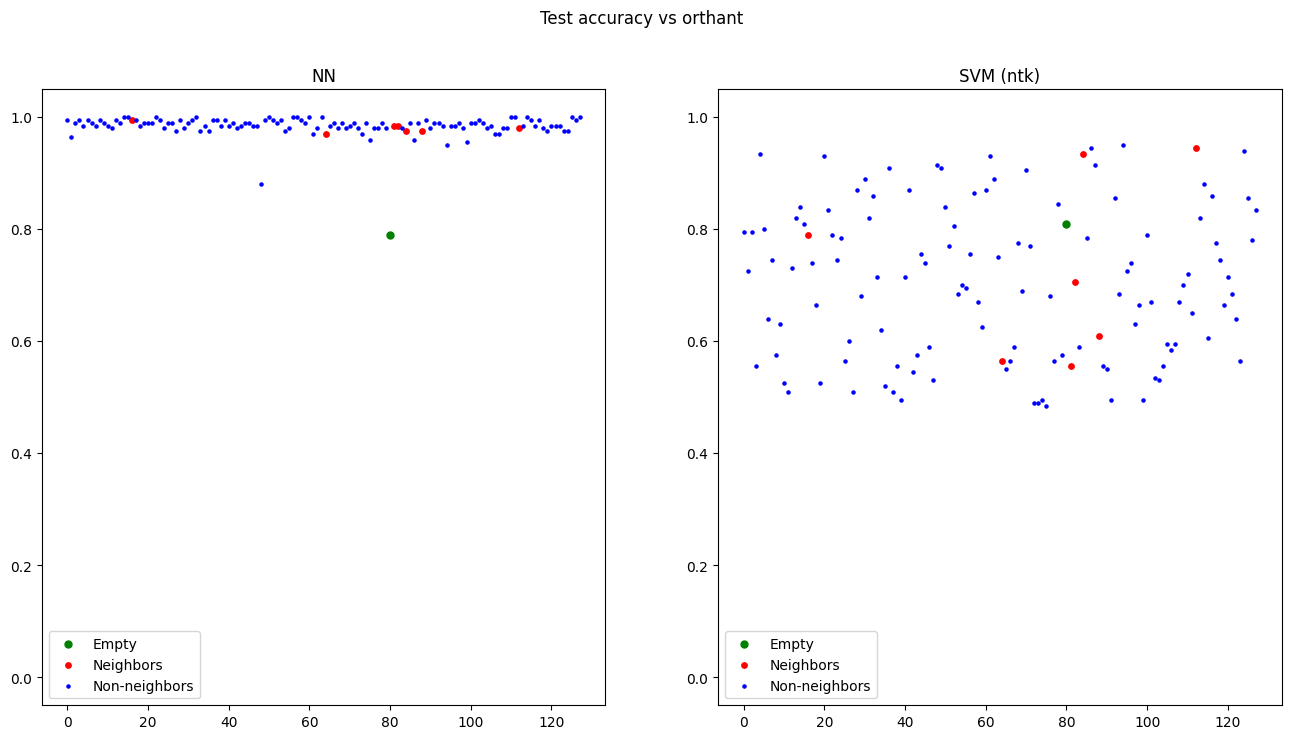

In [73]:
c_arr = np.zeros(128)
c_arr[ZERO_ORTHANT_INDEX] = 2
for i in neighboring_orthants:
    c_arr[i] = 1
non_neighboring_orthants = list(set(range(128)) - set([ZERO_ORTHANT_INDEX]+neighboring_orthants))

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.scatter([ZERO_ORTHANT_INDEX], [scores_nn[ZERO_ORTHANT_INDEX]], c='g', s=25, label='Empty')
plt.scatter(neighboring_orthants, scores_nn[neighboring_orthants], c='r', s=15, label='Neighbors')
plt.scatter(non_neighboring_orthants, scores_nn[non_neighboring_orthants], c='b', s=5, label='Non-neighbors')
plt.legend()
plt.ylim(-0.05, 1.05)
plt.title('NN')

plt.subplot(122)
plt.scatter([ZERO_ORTHANT_INDEX], [scores_km[ZERO_ORTHANT_INDEX]], c='g', s=25, label='Empty')
plt.scatter(neighboring_orthants, scores_km[neighboring_orthants], c='r', s=15, label='Neighbors')
plt.scatter(non_neighboring_orthants, scores_km[non_neighboring_orthants], c='b', s=5, label='Non-neighbors')
plt.legend()
plt.ylim(-0.05, 1.05)
plt.title(f"SVM ({best_config['kernel']})")

plt.suptitle('Test accuracy vs orthant')